NCand2


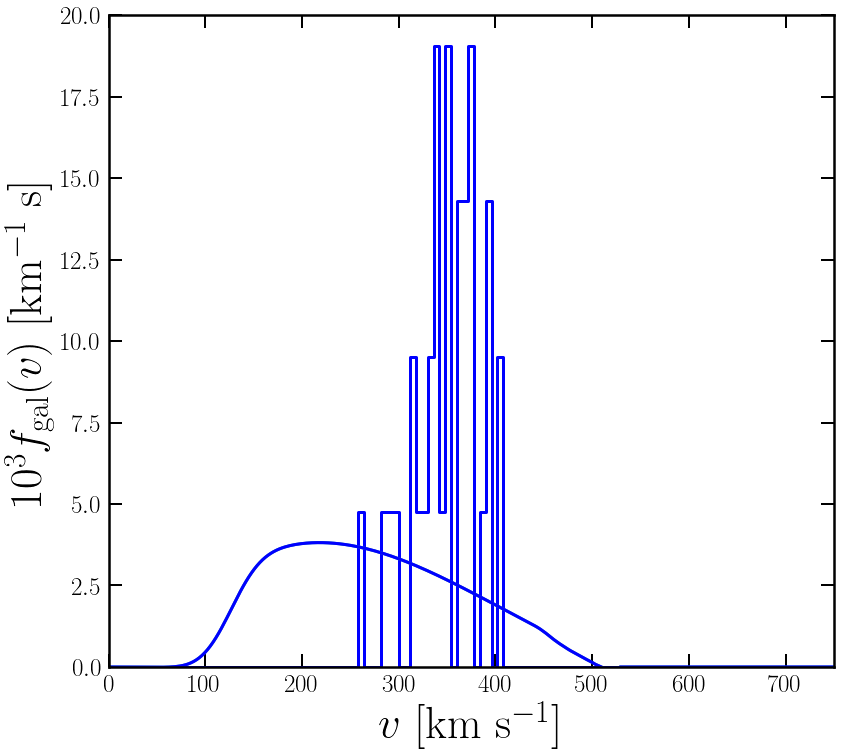

In [10]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

# Load shards
df = pandas.read_csv('../data/FitShards.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
#weights = pops*norm.pdf(Psun,loc=0.0,scale=1.0)/norm.pdf(0.0,loc=0.0,scale=1.0)
weights = pops
weights /= sum(weights)


xlab = r"$v$ [km s$^{-1}$]"
ylab1 = r"$10^3 f_{\rm gal}(v)$ [km$^{-1}$ s]"
n = 300
v = linspace(0.01,850.0,n)
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 
n_xi = 10
xi_max = 0.35
xi_vals = linspace(0.0,xi_max,n_xi)
fig,ax = MySquarePlot(xlab,ylab1)
eta = 0.2




namei = 'NCand2'


df_S = pandas.read_csv('../data/GAIA_SDSS_Shards.csv')
all_names = df_S.group_id.unique()

df_sel = df_S.loc[df_S['group_id']==namei]
vv = sqrt((df_sel.GalRVel)**2.0+(df_sel.GalTVel)**2.0+(df_sel.GalzVel)**2.0)
fv,vbins = histogram(vv,bins=100,normed=True,range=(0,600))
plt.step(vbins[1:],1e3*fv,'-',color='b',lw=3)

fv_gal1 = zeros(shape=n)
for i in range(0,nshards):
    if names[i] in [namei,namei+'a',namei+'b']:
        v_s = velocities[i,:]
        sig_s = dispersions[i,:]
        fv_gal1 += weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GalFrame=True,SmoothCutoff=True)
        plt.plot(v,1e3*fv_gal1/trapz(fv_gal1,v),'-',lw=3)
        print names[i]
        
plt.plot(v,1e3*fv_gal1/trapz(fv_gal1,v),'b-',lw=3)

    

plt.xlim([0,750])
ax.set_ylim(bottom=0.0)
plt.show()

In [22]:
sig_s

array([ 43.02999757,  14.40389608,   8.11077384])

In [8]:
x_meens,x_covs,v_meens,v_covs,fehs,pops,Psun = FitStars(df_sel)
print v_meens,sqrt(sum(v_meens[0,:]**2.0))
print mean(df_sel.GalRVel),mean(df_sel.GalTVel),mean(df_sel.GalzVel),mean(vv)
print mean(vv)/sqrt(sum(v_meens[0,:]**2.0))
fig = VelocityTriangle(df_sel)
plt.show()

[[ -81.30473379  120.30012232   45.36846196]] 152.12125594
-81.3047337937 120.300122321 45.368461964 349.448414658
2.29717019163


TypeError: RemovePhaseSpaceOutliers() takes at least 7 arguments (7 given)

0 0.0107293329428
1 0.031421617904
2 0.0375526652998
3 0.0406181889977
4 0.0436837126957
5 0.0452164745447
6 0.0501979505538
7 0.0532634742518
8 0.0547962361007
9 0.0574785693364
10 0.0597777121099
11 0.0689742832037
12 0.0781708542976
13 0.0800868066088
14 0.083535520769
15 0.0973303774097
16 0.108826091277
17 0.109975662664
18 0.120321805144
19 0.121471376531
20 0.129135185776
21 0.132583899936
22 0.143313232879
23 0.15519213721
24 0.162472755992
25 0.165921470153
26 0.167837422464
27 0.171669327086
28 0.176267612633
29 0.17741718402
30 0.181249088642
31 0.182781850491
32 0.185847374189
33 0.187380136038
34 0.190445659736
35 0.19619351667
36 0.198109468981
37 0.201941373603
38 0.212670706546
39 0.213820277933
40 0.218035373018
41 0.221100896715
42 0.223016849027
43 0.2253159918
44 0.22876470596
45 0.231830229658
46 0.232979801045
47 0.235662134281
48 0.239110848441
49 0.241793181677
50 0.249073800459
51 0.252905705082
52 0.255204847855
53 0.25941994294
54 0.263635038024
55 0.26478460

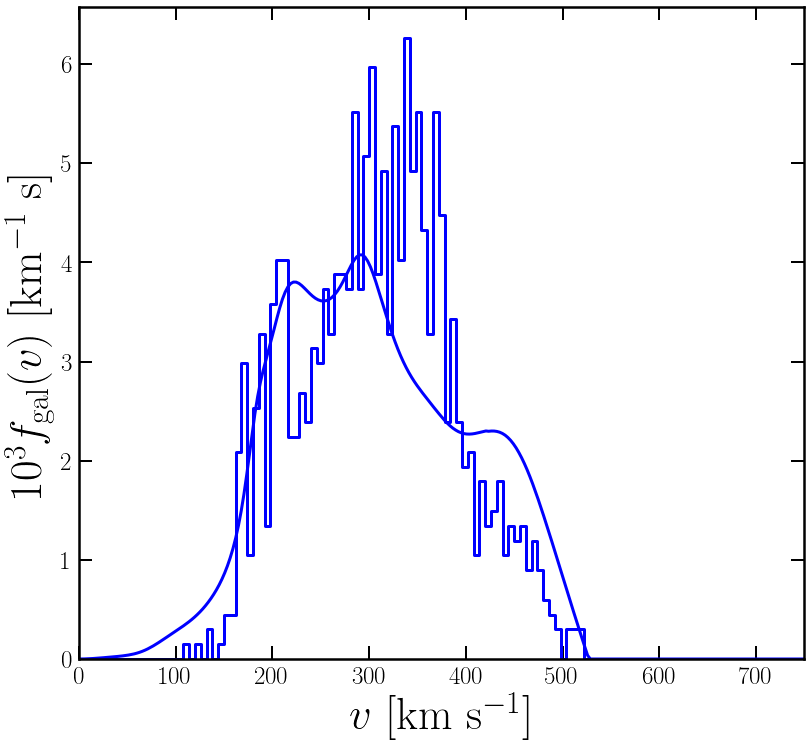

In [2]:
fig,ax = MySquarePlot(xlab,ylab1)
eta = 0.2


df_S = pandas.read_csv('../data/GAIA_SDSS_Shards.csv')
all_names = df_S.group_id.unique()
df_sel = df_S
vv = sqrt((df_sel.GalRVel)**2.0+(df_sel.GalTVel)**2.0+(df_sel.GalzVel)**2.0)
fv,vbins = histogram(vv,bins=100,normed=True,range=(0,600))
plt.step(vbins[1:],1e3*fv,'-',color='b',lw=3)

fv_gal1 = zeros(shape=n)
for i in range(0,nshards):
    v_s = velocities[i,:]
    sig_s = dispersions[i,:]
    fv_gal1 += weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GalFrame=True,SmoothCutoff=True)
    print i,sum(fv_gal1)
plt.plot(v,1e3*fv_gal1/trapz(fv_gal1,v),'b-',lw=3)

    
plt.xlim([0,750])
ax.set_ylim(bottom=0.0)
plt.show()

In [3]:
df

,group_id,x,y,z,dx,dy,dz,vx,vy,vz,sigx,sigy,sigz,feh,dfeh,population,Psun
0,S1,8.364273,0.568172,2.612509,0.540881,1.314853,0.884068,-15.294460,-302.833400,-79.773792,101.100048,35.248909,52.767097,-1.933356,0.255283,28.0,2.184017
1,S2,8.875749,0.198735,0.157000,0.596699,0.936686,2.451619,0.640222,162.327503,-238.369638,46.284083,14.500559,25.372084,-1.946772,0.236097,54.0,0.502575
2,C2,8.745746,-0.741814,2.670906,1.045283,0.778070,1.880257,-347.994053,105.540568,270.883887,45.093378,32.404226,84.738533,-1.443843,0.127125,16.0,0.808440
3,Rg1a,8.388699,1.409191,4.425992,0.624306,1.659692,1.017574,-3.585488,-380.297282,223.762670,53.767423,22.115621,50.510302,-1.459797,0.142515,8.0,3.733830
4,Rg1b,8.043067,-0.930250,4.106035,1.053001,1.475750,0.751025,145.966907,-408.253981,-60.225094,119.565987,49.184338,65.143838,-1.675899,0.119409,8.0,4.849141
5,Rg2a,9.155584,1.251465,3.704074,0.358015,0.443550,1.524472,46.126474,-244.955709,-199.867586,94.316732,17.744995,39.777107,-1.647580,0.029896,4.0,4.013791
6,Rg2b,8.933350,0.292586,4.366950,0.757699,2.076280,2.670193,44.463356,-248.409084,185.176718,105.948147,23.089300,63.468679,-1.610013,0.201529,13.0,1.080687
7,Rg3a,8.825712,0.360817,4.551375,1.496954,2.240105,1.269816,151.695172,-292.273818,86.254735,70.025173,55.170917,103.995529,-1.511130,0.227052,8.0,2.841053
8,Rg3b,8.564128,0.552957,3.755197,1.155250,1.523806,1.596491,-157.296030,-294.638451,-78.389233,91.403443,49.352730,95.391458,-1.436980,0.272992,4.0,1.546580
9,Rg4a,7.418481,1.592759,4.698267,0.925852,1.457135,1.287317,98.625491,-310.352089,249.824308,93.544021,32.458985,39.696081,-1.447738,0.089184,7.0,3.127521


In [7]:
Cand = df_sel


# Get data
name = Cand.group_id.unique()[0]
nstars = size(Cand,0)
feh = Cand.feh # metallicity
vx,vy,vz = Cand.GalRVel,Cand.GalTVel,Cand.GalzVel # velocities
x,y,z = Cand.GalRecX,Cand.GalRecY,Cand.GalRecZ # positions
    # Get data
    name = Cand.group_id.unique()[0]
    nstars = size(Cand,0)
    feh = Cand.feh # metallicity
    vx,vy,vz = Cand.GalRVel,Cand.GalTVel,Cand.GalzVel # velocities
    x,y,z = Cand.GalRecX,Cand.GalRecY,Cand.GalRecZ # positions

    # Remove outliers if needed
    if RemoveOutliers:
        x_red,y_red,z_red,vx_red,vy_red,vz_red,feh_red = RemovePhaseSpaceOutliers(x,y,z,vx,vy,vz,feh,z_th=z_th)
        data1 = array([x_red,y_red,z_red,vx_red,vy_red,vz_red,feh]).T
    else:
        data2 = array([x,y,z,vx,vy,vz,feh]).T



In [22]:
df

,group_id,x,y,z,dx,dy,dz,vx,vy,vz,sigx,sigy,sigz,feh,dfeh,population,Psun
0,S1a,8.144755,-0.336208,2.756541,0.415441,1.134558,0.611698,90.894975,-310.370134,-52.099832,47.926726,25.198756,62.975690,-1.833847,0.205878,12.0,4.228009
1,S1b,8.529249,1.247849,2.504264,0.565044,0.992010,1.029779,-95.099864,-297.169258,-100.571828,36.513025,40.302352,29.803500,-2.008142,0.263168,16.0,1.782909
2,S2a,8.875749,0.198735,0.157000,0.596699,0.936686,2.451619,0.640222,162.327503,-238.369638,46.284083,14.500559,25.372084,-1.946772,0.236097,54.0,0.454685
3,S2b,8.833954,0.771728,2.070132,1.324201,0.021803,1.294304,16.347258,156.078969,240.090428,23.277248,10.316115,38.919084,-1.810805,0.208692,2.0,inf
4,C2a,8.745746,-0.741814,2.670906,1.045283,0.778070,1.880257,-347.994053,105.540568,270.883887,45.093378,32.404226,84.738533,-1.443843,0.127125,16.0,0.932476
5,C2b,9.073969,-1.066600,3.050773,0.001000,0.001000,0.001000,354.728426,120.197904,-259.071198,0.001000,0.001000,0.001000,-1.358053,0.001000,1.0,inf
6,Rg1a,8.289840,-1.240535,4.056581,0.883198,1.311008,0.790601,173.501716,-396.185835,-66.361588,101.355754,39.994542,67.444146,-1.668084,0.125725,7.0,4.550133
7,Rg1b,8.158361,1.390586,4.428906,0.878006,1.565657,0.959414,-8.384518,-392.789918,196.981303,52.478245,41.027842,89.474839,-1.489887,0.159050,9.0,3.998985
8,Rg2a,8.933350,0.292586,4.366950,0.757699,2.076280,2.670193,44.463356,-248.409084,185.176718,105.948147,23.089300,63.468679,-1.610013,0.201529,13.0,1.080687
9,Rg2b,9.155584,1.251465,3.704074,0.358015,0.443550,1.524472,46.126474,-244.955709,-199.867586,94.316732,17.744995,39.777107,-1.647580,0.029896,4.0,4.013791


In [27]:
weights

0     0.013699
1     0.018265
2     0.061644
3     0.002283
4     0.018265
5     0.001142
6     0.007991
7     0.010274
8     0.014840
9     0.004566
10    0.004566
11    0.009132
12    0.010274
13    0.014840
14    0.012557
15    0.015982
16    0.011416
17    0.009132
18    0.004566
19    0.017123
20    0.023973
21    0.011416
22    0.026256
23    0.022831
24    0.011416
25    0.022831
26    0.010274
27    0.010274
28    0.021689
29    0.021689
        ...   
61    0.004566
62    0.018265
63    0.009132
64    0.009132
65    0.004566
66    0.005708
67    0.006849
68    0.006849
69    0.009132
70    0.002283
71    0.012557
72    0.007991
73    0.009132
74    0.003425
75    0.012557
76    0.010274
77    0.010274
78    0.006849
79    0.005708
80    0.009132
81    0.003425
82    0.007991
83    0.006849
84    0.007991
85    0.005708
86    0.011416
87    0.009132
88    0.007991
89    0.005708
90    0.006849
Name: population, Length: 91, dtype: float64

In [29]:
dispersions

array([[  4.79267258e+01,   2.51987558e+01,   6.29756905e+01],
       [  3.65130250e+01,   4.03023516e+01,   2.98034999e+01],
       [  4.62840834e+01,   1.45005595e+01,   2.53720835e+01],
       [  2.32772481e+01,   1.03161148e+01,   3.89190836e+01],
       [  4.50933782e+01,   3.24042264e+01,   8.47385328e+01],
       [  1.00000000e-03,   1.00000000e-03,   1.00000000e-03],
       [  1.01355754e+02,   3.99945425e+01,   6.74441456e+01],
       [  5.24782454e+01,   4.10278418e+01,   8.94748388e+01],
       [  1.05948147e+02,   2.30892996e+01,   6.34686793e+01],
       [  9.43167322e+01,   1.77449947e+01,   3.97771069e+01],
       [  9.14034429e+01,   4.93527298e+01,   9.53914584e+01],
       [  7.00251728e+01,   5.51709169e+01,   1.03995529e+02],
       [  6.44045612e+01,   2.61454401e+01,   1.74882616e+02],
       [  5.09293524e+01,   1.74109408e+01,   3.49034755e+01],
       [  5.33596519e+01,   1.81583146e+01,   3.27333960e+01],
       [  8.12160310e+01,   3.14915401e+01,   9.5658724